<a href="https://colab.research.google.com/github/Viny2030/tensorflow/blob/main/Generaci%C3%B3n_de_texto_con_Redes_Recurrentes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este tutorial veremos de forma práctica cómo usar Python y las librerías TensorFlow y Keras para entrenar y poner a prueba una Red Recurrente capaz de generar texto.

En particular veremos cómo implementar una Red Neuronal Recurrente capaz de generar nombres de dinosaurios. Para ello usaremos Python y la librería Keras e implementaremos el código para la lectura de los datos, para implementar y entrenar la red recurrente y para generar nombres una vez realizado el entrenamiento.

Al final del tutorial se encuentra el enlace para descargar el set de datos y el código fuente.

¡Así que listo, comencemos!

# Introducción
Recordemos que una Red Neuronal Recurrente es una arquitectura que permite analizar secuencias (como texto, conversaciones o videos).

Para ello usa el concepto de recurrencia: además de generar un dato de salida, genera algo conocido como el “estado oculto” (o hidden state), encargado de almacenar la información presente en instantes previos de la secuencia.

En dos artículos anteriores vimos una introducción a las Redes Neuronales Recurrentes y una explicación detallada de las Redes Recurrentes. Te invito a revisar estos artículos si quieres conocer los detalles de funcionamiento de esta arquitectura del Deep Learning.

Descripción de la Red Recurrente a entrenar
Para entrenar la red recurrente de este tutorial usaremos un set de datos que contiene nombres de dinosaurios.

El objetivo es que la red tome un caracter de entrada y aprenda a predecir el siguiente caracter en la secuencia, generando así nuevos nombres de dinosaurios:

Ejemplo de funcionamiento de la Red Recurrente que entrenaremos en este tutorial
Ejemplo de funcionamiento de la Red Recurrente que entrenaremos en este tutorial

El código que implementaremos está dividido en cinco partes: importación de librerías, lectura de los datos, implementación del modelo en Keras, entrenamiento y generación de nombres con el modelo ya entrenado.

Veamos entonces paso a paso cómo realizar esta implementación.

Importación de librerías
Las librerías que necesitamos en este caso son similares a las usadas en tutoriales anteriores.

Usaremos Numpy y ajustaremos la semilla del generador aleatorio para garantizar la reproducibilidad del entrenamiento:

In [1]:
import numpy as np
np.random.seed(5)

Después importaremos de Keras las funciones Input y Dense, y especialmente prestaremos atención a SimpleRNN, que nos permite precisamente crear una celda recurrente:

In [2]:
from keras.layers import Input, Dense, SimpleRNN

Después importaremos Model y el optimizador del Gradiente Descendente (SGD) que nos permitirán crear y entrenar el modelo:

In [3]:
from keras.models import Model
from keras.optimizers import SGD

Finalmente importaremos “to_categorical” y el backend para poder representar la entrada y salida al modelo en el formato adecuado durante el entrenamiento y la durante la predicción:

In [4]:
from keras.utils import to_categorical
from keras import backend as K

Lectura y pre-procesamiento del set de datos
El set de entrenamiento está almacenado en un archivo de texto (al final del artículo encontrarás el enlace de descarga), y contiene un total de 1536 nombres de dinosaurios.

La lectura es sencilla: usamos la función open de Python, y posteriormente representamos todos los caracteres en minúscula usando el método lower

In [6]:
url = "https://raw.githubusercontent.com/Viny2030/datasets/refs/heads/main/nombres_dinosaurios.txt"

In [9]:
nombres = open('/content/nombres_dinosaurios.txt','r').read()
nombres = nombres.lower()

Como la Red Recurrente no acepta caracteres a la entrada, debemos convertir cada uno de estos a una representación numérica.

Para ello definiremos un alfabeto, que corresponde a los diferentes caracteres que conforman el set de datos.

Esto lo logramos de forma sencilla usando la función set de Python. Simplemente introducimos el contenido del archivo de texto y la función set encuentra el listado de caracteres únicos:

In [10]:
alfabeto = list(set(nombres))
tam_datos, tam_alfabeto = len(nombres), len(alfabeto)

In [11]:
alfabeto

['g',
 'p',
 'd',
 'j',
 's',
 'k',
 'i',
 't',
 'u',
 'w',
 'l',
 'm',
 'c',
 'e',
 'y',
 'b',
 'x',
 'q',
 'z',
 'o',
 'f',
 '\n',
 'h',
 'r',
 'n',
 'a',
 'v']

In [12]:
tam_datos

19909

In [13]:
tam_alfabeto

27

Aunque el set de datos contiene 19909 caracteres, el alfabeto consta de tan solo 27 caracteres, dentro de los cuales se incluye el carácter de cambio de línea que indica el final de cada nombre:

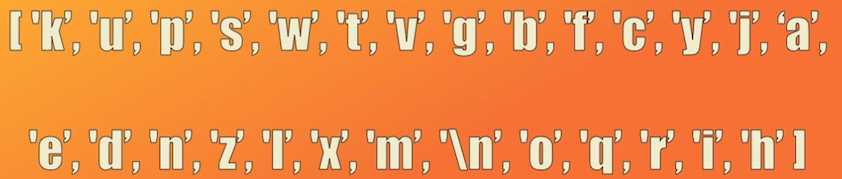

La idea es que durante el entrenamiento cada carácter será representado en el formato one-hot, es decir con un vector de 27 elementos (el tamaño del alfabeto) donde sólo uno de estos elementos será diferente de cero:

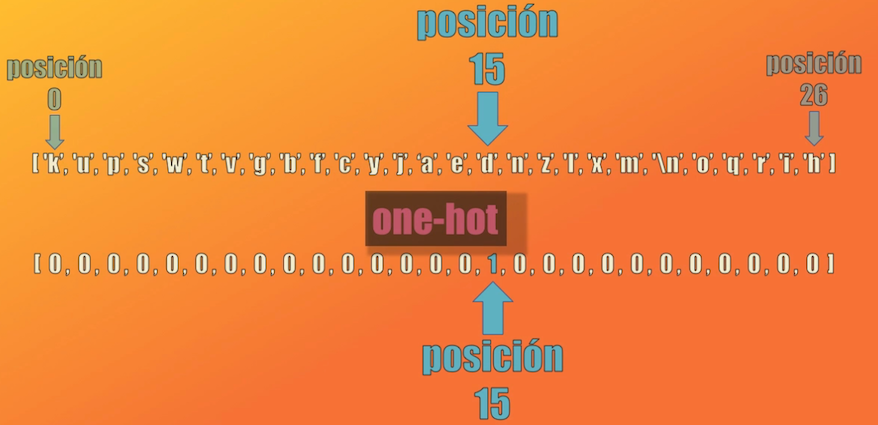

Para realizar esta conversión necesitamos entonces un diccionario, que nos permita definir la equivalencia correspondiente entre el carácter y el índice correspondiente dentro del vector one-hot.

Para hacer esto simplemente creamos un diccionario en Python, definiendo para cada carácter del alfabeto un índice (o numero entero):

In [14]:
car_a_ind = { car:ind for ind,car in enumerate(sorted(alfabeto))}

In [15]:
car_a_ind

{'\n': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

Así por ejemplo, el cambio de línea será representado con el índice 0, la “a” con el 1, la “b” con el 2 y así sucesivamente:

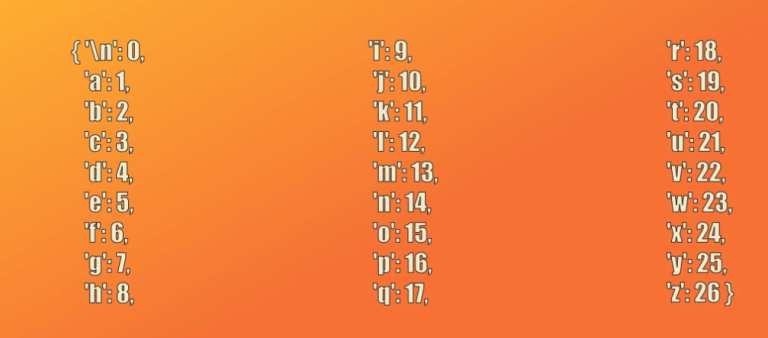

De igual forma, una vez entrenada la Red Recurrente, seremos capaces de generar números (no caracteres) a la salida de la misma. Por tanto, para obtener el nombre generado, debemos realizar el proceso inverso: convertir vectores one-hot a su carácter correspondiente, para lo cual crearemos un segundo diccionario que permite mapear índices a caracteres:

In [16]:
ind_a_car = { ind:car for ind,car in enumerate(sorted(alfabeto))}

In [17]:
ind_a_car

{0: '\n',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}

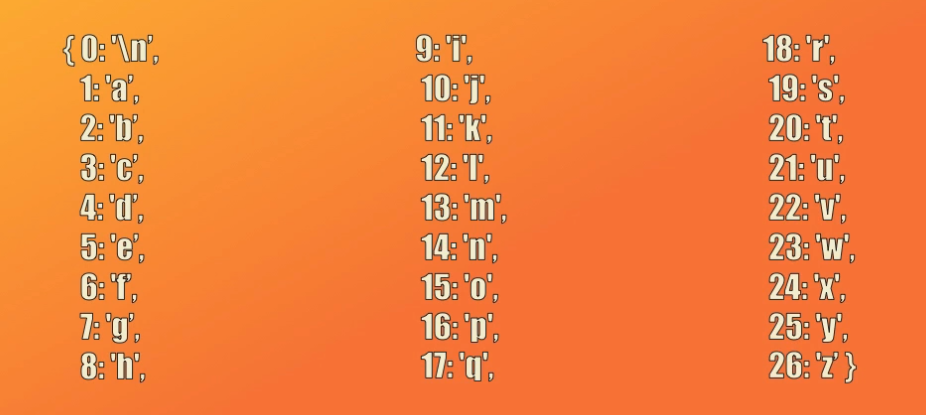

# Creación de la Red Recurrente en Keras
Veamos ahora las características del modelo a implementar:

Tendrá dos entradas:

 x(un carácter del set de entrenamiento) que se representará en el formato one-hot como un vector con 27 elementos (que es el tamaño del alfabeto)
 at-1(el estado oculto en el instante de tiempo anterior) que se representará con un vector de 25 elementos (que será el mismo tamaño de la capa oculta)
Además, el modelo generará dos salidas:

y (la predicción, o el carácter generado por el modelo) que, al igual que la entrada, se representará como un vector con 27 elementos en formato one-hot
 at(el estado oculto en el instante de tiempo actual), un vector también de 25 elementos.


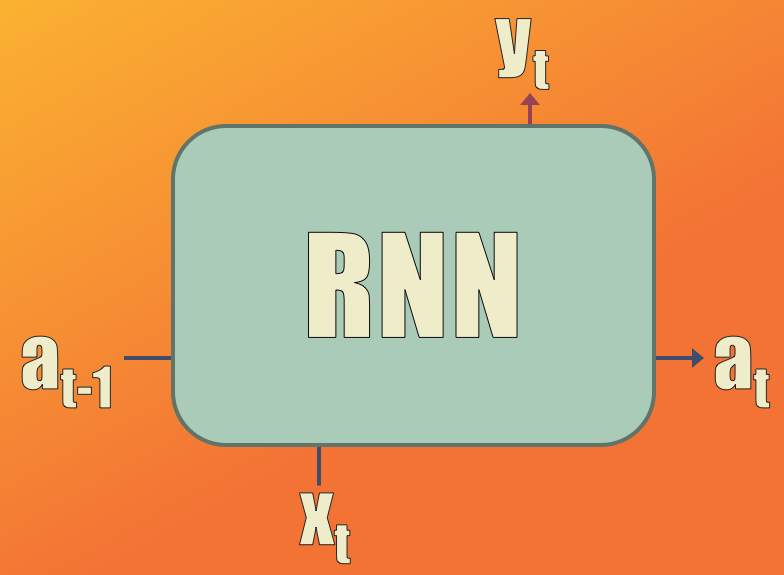

# *Para implementar este modelo usaremos dos elementos:*

Una celda recurrente, que tomará la entrada
 y el estado oculto anterior, y generará el nuevo estado oculto usando la función de activación tangente hiperbólica
Una capa de salida con función de activación softmax, que tomará la activación generada por la celda recurrente y generará la salida
 o predicción

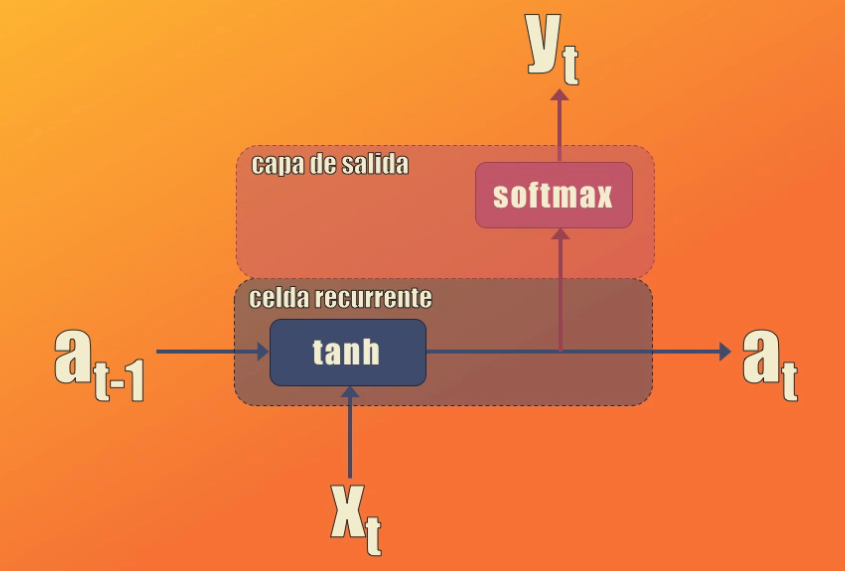

Estos dos elementos (la celda recurrente y la capa softmax) los usaremos más adelante para la generación de nombres, una vez hayamos entrenado el modelo.

La implementación de este modelo es sencilla en Keras. En primer lugar definimos el número de neuronas de la capa oculta (es decir 25), y creamos dos contenedores:

Uno para la entrada (x
 en el diagrama anterior), en donde hemos usado la palabra clave None, lo cual nos permite tener entradas (es decir nombres de dinosaurio) con tamaños variables.
Uno para el estado oculto (at-1
 en el diagrama anterior), que será precisamente un vector con 25 elementos

In [18]:
n_a = 25    # Número de unidades en la capa oculta
entrada  = Input(shape=(None,tam_alfabeto))
a0 = Input(shape=(n_a,))

Ahora creamos la celda recurrente. Para ello usamos la función SimpleRNN importada anteriormente.

Esta celda tendrá 25 neuronas, función de activación tangente hiperbólica y usaremos la palabra clave return_state para que a la salida nos entregue el nuevo estado oculto actualizado:

In [19]:
celda_recurrente = SimpleRNN(n_a, activation='tanh', return_state = True)

Ahora creamos la capa softmax. Para ello usamos la función Dense. Esta capa tendrá 27 neuronas de salida (el tamaño del alfabeto) y usará precisamente la función de activación “softmax”:

In [20]:
capa_salida = Dense(tam_alfabeto, activation='softmax')

Finalmente creamos un modelo en Keras, usando la función Model importada anteriormente.

Para ello instanciamos la celda recurrente, agregando las dos entradas definidas anteriormente. Posteriormente creamos la variable “salida” y en ella almacenamos la activación entregada por la celda recurrente.

In [21]:
hs, _ = celda_recurrente(entrada, initial_state=a0)
salida = []
salida.append(capa_salida(hs))

Ahora creamos el modelo, dejando explícito que tendremos dos entradas (el caracter actual y el estado oculto anterior) y la salida correspondiente a la predicción:

In [22]:
modelo = Model([entrada,a0],salida)

Por último (al igual que lo hacíamos en el caso de las Redes Neuronales o Convolucionales, creamos el optimizador (Gradiente Descendente) y lo añadimos al modelo:

In [26]:
from keras.optimizers import SGD # or tensorflow.keras.optimizers if using tf.keras

opt = SGD(learning_rate=0.0005) # Change 'lr' to 'learning_rate'
modelo.compile(optimizer=opt, loss='categorical_crossentropy')

# Entrenamiento de la Red Recurrente
Para el entrenamiento generamos inicialmente una lista con los nombres de cada dinosaurio y los mezclamos aleatoriamente, usando np.random.shuffle como lo vemos en las siguientes líneas de código:

In [27]:
with open("nombres_dinosaurios.txt") as f:
    ejemplos = f.readlines()
ejemplos = [x.lower().strip() for x in ejemplos]
np.random.shuffle(ejemplos)

In [28]:
ejemplos

['sinosaurus',
 'bonitasaura',
 'stegosaurides',
 'rapator',
 'pareiasaurus',
 'apatodon',
 'ningyuansaurus',
 'saurophagus',
 'tangvayosaurus',
 'harpymimus',
 'ornithoides',
 'cheneosaurus',
 'heishansaurus',
 'zhenyuanlong',
 'gresslyosaurus',
 'algoasaurus',
 'orodromeus',
 'torvosaurus',
 'aquilops',
 'veterupristisaurus',
 'wyleyia',
 'teratophoneus',
 'gyposaurus',
 'longosaurus',
 'yuanmouraptor',
 'einiosaurus',
 'kakuru',
 'ponerosteus',
 'cruxicheiros',
 'pleurocoelus',
 'magnapaulia',
 'vagaceratops',
 'bolong',
 'iliosuchus',
 'ozraptor',
 'chuandongocoelurus',
 'fusinasus',
 'variraptor',
 'jinfengopteryx',
 'doryphorosaurus',
 'elmisaurus',
 'campylodon',
 'nodocephalosaurus',
 'janenschia',
 'hanssuesia',
 'padillasaurus',
 'bicentenaria',
 'sinopelta',
 'tongtianlong',
 'shunosaurus',
 'lancanjiangosaurus',
 'huxleysaurus',
 'willinakaqe',
 'shidaisaurus',
 'palaeoctonus',
 'daliansaurus',
 'orthogoniosaurus',
 'qijianglong',
 'texacephale',
 'ultrasauros',
 'shixinggi

Después definimos una función que tome uno a uno cada ejemplo de entrenamiento y que genere tres vectores, que serán las entradas al modelo:

In [35]:
def train_generator():
    while True:
        # Tomar un ejemplo aleatorio
        ejemplo = ejemplos[np.random.randint(0,len(ejemplos))]

        # Convertir el ejemplo a representación numérica
        X = [None] + [car_a_ind[c] for c in ejemplo]

        # Crear "Y", resultado de desplazar "X" un caracter a la derecha
        Y = X[1:] + [car_a_ind['\n']]

        # Representar "X" y "Y" en formato one-hot
        x = np.zeros((len(X),1,tam_alfabeto))
        onehot = to_categorical(X[1:],tam_alfabeto).reshape(len(X)-1,1,tam_alfabeto)
        x[1:,:,:] = onehot

        # Activación inicial (matriz de ceros)
        a = np.zeros((len(X), n_a))

        yield [x, a]

Veamos paso a paso los vectores generados por esta función:

# La entrada
, correspondiente a un nombre de dinosaurio tomado aleatoriamente del set de entrenamiento. Cada carácter será representado primero como un número entero (usando el diccionario creado al inicio del código) y luego representado en formato one-hot. Entrenaremos el modelo para que el primer carácter presentado sea siempre un vector de ceros:

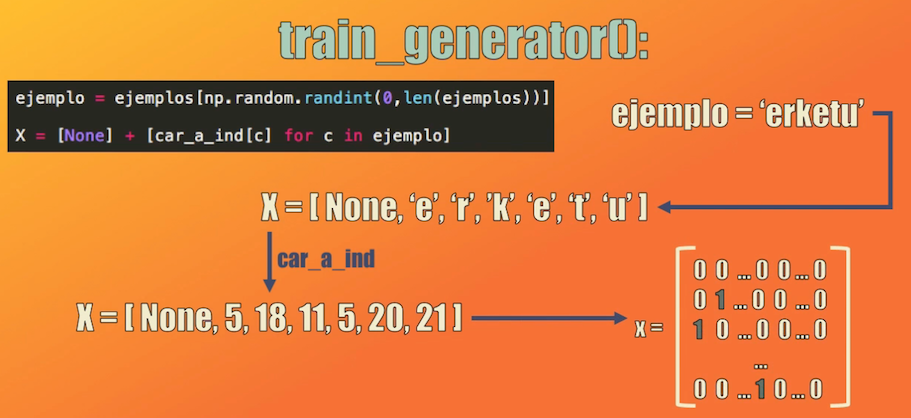

# Código y procedimiento para generar el vector X (la entrada a nuestra Red Recurrente para la generación de texto)
`La salida `
, que será simplemente el resultado de tomar la entrada y desplazarla un carácter a la derecha. De nuevo, cada carácter es representado con un índice correspondiente y luego convertido al formato one-hot:

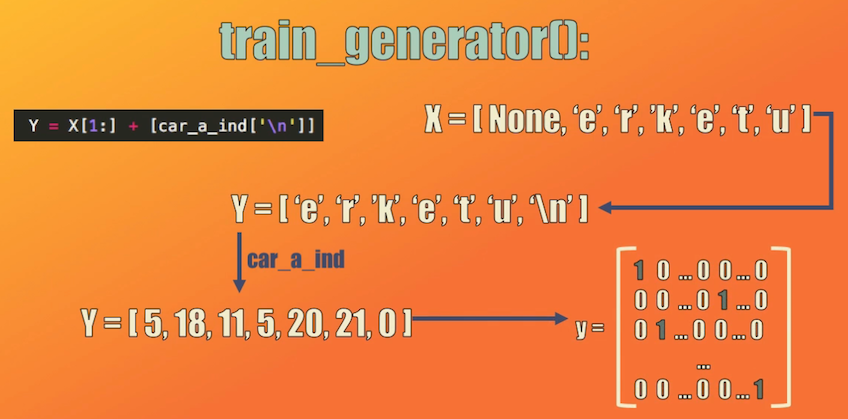

Código y procedimiento para generar el vector Y (la salida de nuestra Red Recurrente para la generación de texto)
Finalmente definimos la activación inicial que será simplemente una matriz de ceros, y que se irá actualizando a medida que se presentan uno a uno los caracteres al modelo durante el entrenamiento:

In [37]:
a = np.zeros((len(X)), n_a)

NameError: name 'X' is not defined

Para entrenar esta Red Recurrente definimos un total de 10000 iteraciones, en cada una de las cuales presentaremos 80 ejemplos de entrenamiento.

El entrenamiento lo haremos con el método fit_generator fit_generator, y como parámetros de entrada tendremos la función creada anteriormente (train_generator) que permite crear un ejemplo de entrenamiento, así como el número de ejemplos a usar durante cada iteración (es decir 80): fit_

In [38]:
BATCH_SIZE = 80			# Número de ejemplos de entrenamiento a usar en cada iteración
NITS = 10000			# Número de iteraciones

for j in range(NITS):
    historia = modelo.fit_generator(train_generator(), steps_per_epoch=BATCH_SIZE, epochs=1, verbose=0)

    # Imprimir evolución del entrenamiento cada 1000 iteraciones
    if j%1000 == 0:
        print('\nIteración: %d, Error: %f' % (j, historia.history['loss'][0]) + '\n')

AttributeError: 'Functional' object has no attribute 'fit_generator'

Predicción con la Red Recurrente: generación de nombres de dinosaurios
Para generar los nombres con el modelo entrenado usaremos la celda recurrente y la capa de salida softmax creadas anteriormente y ya entrenadas en el paso anterior. Para esto crearemos la función gen

In [46]:
def generar_nombre(modelo,car_a_num,tam_alfabeto,n_a):
    # Inicializar x y a con ceros
    x = np.zeros((1,1,tam_alfabeto,))
    a = np.zeros((1, n_a))

    # Nombre generado y caracter de fin de linea
    nombre_generado = ''
    fin_linea = '\n'
    car = -1

    # Iterar sobre el modelo y generar predicción hasta tanto no se alcance
    # "fin_linea" o el nombre generado llegue a los 50 caracteres
    contador = 0
    while (car != fin_linea and contador != 50):
          # Generar predicción usando la celda RNN
          a, _ = celda_recurrente(K.constant(x), initial_state=K.constant(a))
          y = capa_salida(a)
          prediccion = K.eval(y)

          # Escoger aleatoriamente un elemento de la predicción (el elemento con
          # con probabilidad más alta tendrá más opciones de ser seleccionado)
          ix = np.random.choice(list(range(tam_alfabeto)),p=prediccion.ravel())

          # Convertir el elemento seleccionado a caracter y añadirlo al nombre generado
          car = ind_a_car[ix]
          nombre_generado += car

          # Crear x_(t+1) = y_t, y a_t = a_(t-1)
          x = to_categorical(ix,tam_alfabeto).reshape(1,1,tam_alfabeto)
          a = K.eval(a)

          # Actualizar contador y continuar
          contador += 1

          # Agregar fin de línea al nombre generado en caso de tener más de 50 caracteres
          if (contador == 50):
            nombre_generado += '\n'

    print(nombre_generado)

Al iniciar la predicción introduciremos a la celda inicialmente vectores de ceros tanto para la entrada “x” como para el estado oculto anterior:

In [47]:
    x = np.zeros((1,1,tam_alfabeto,))
    a = np.zeros((1, n_a))

Luego llevaremos la activación resultante a la capa softmax para generar así la predicción:

In [50]:
def generar_nombre(modelo,car_a_num,tam_alfabeto,n_a):
    # Inicializar x y a con ceros
    x = np.zeros((1,1,tam_alfabeto,))
    a = np.zeros((1, n_a))

    # Nombre generado y caracter de fin de linea
    nombre_generado = ''
    fin_linea = '\n'
    # Initialize 'car' before the loop to avoid NameError
    car = ''  # Or any initial value that's not fin_linea

    # Iterar sobre el modelo y generar predicción hasta tanto no se alcance
    # "fin_linea" o el nombre generado llegue a los 50 caracteres
    contador = 0
    while (car != fin_linea and contador != 50):
          # Generar predicción usando la celda RNN
          a, _ = celda_recurrente(K.constant(x), initial_state=K.constant(a))
          y = capa_salida(a)
          prediccion = K.eval(y)

          # Escoger aleatoriamente un elemento de la predicción (el elemento con
          # con probabilidad más alta tendrá más opciones de ser seleccionado)
          ix = np.random.choice(list(range(tam_alfabeto)),p=prediccion.ravel())

          # Convertir el elemento seleccionado a caracter y añadirlo al nombre generado
          car = ind_a_car[ix]
          nombre_generado += car

          # Crear x_(t+1) = y_t, y a_t = a_(t-1)
          x = to_categorical(ix,tam_alfabeto).reshape(1,1,tam_alfabeto)
          a = K.eval(a)

          # Actualizar contador y continuar
          contador += 1

          # Agregar fin de línea al nombre generado en caso de tener más de 50 caracteres
          if (contador == 50):
            nombre_generado += '\n'

    print(nombre_generado)

In [49]:
while (car != fin_linea and contador != 50):
          # Generar predicción usando la celda RNN
          a, _ = celda_recurrente(K.constant(x), initial_state=K.constant(a))
          y = capa_salida(a)
          prediccion = K.eval(y)

NameError: name 'car' is not defined

Esta predicción será un vector con 27 elementos, que representa una distribución de probabilidad. La idea es escoger aleatoriamente una de estas 27 posiciones, para lo cual usamos la función “choice” de numpy. Desde luego, la posición del elemento con la probabilidad más alta tendrá más opciones de ser seleccionada:

In [51]:
ix = np.random.choice(list(range(tam_alfabeto)),p=prediccion.ravel())

NameError: name 'prediccion' is not defined

Una vez definida la posición buscamos el carácter correspondiente según el diccionario definido anteriormente y lo añadimos al nombre generado:

In [52]:
car = ind_a_car[ix]
nombre_generado += car

NameError: name 'ix' is not defined

In [53]:
def generar_nombre(modelo,car_a_num,tam_alfabeto,n_a):
    # Inicializar x y a con ceros
    x = np.zeros((1,1,tam_alfabeto,))
    a = np.zeros((1, n_a))

    # Nombre generado y caracter de fin de linea
    nombre_generado = ''
    fin_linea = '\n'
    # Initialize 'car' before the loop to ensure the loop runs at least once
    car = ''  # Initialize car to an empty string to ensure the loop runs

    # Iterar sobre el modelo y generar predicción hasta tanto no se alcance
    # "fin_linea" o el nombre generado llegue a los 50 caracteres
    contador = 0
    while (car != fin_linea and contador != 50):
          # Generar predicción usando la celda RNN
          a, _ = celda_recurrente(K.constant(x), initial_state=K.constant(a))
          y = capa_salida(a)
          prediccion = K.eval(y)

          # Escoger aleatoriamente un elemento de la predicción (el elemento con
          # con probabilidad más alta tendrá más opciones de ser seleccionado)
          ix = np.random.choice(list(range(tam_alfabeto)),p=prediccion.ravel())

          # Convertir el elemento seleccionado a caracter y añadirlo al nombre generado
          car = ind_a_car[ix]
          nombre_generado += car

          # Crear x_(t+1) = y_t, y a_t = a_(t-1)
          x = to_categorical(ix,tam_alfabeto).reshape(1,1,tam_alfabeto)
          a = K.eval(a)

          # Actualizar contador y continuar
          contador += 1

          # Agregar fin de línea al nombre generado en caso de tener más de 50 caracteres
          if (contador == 50):
            nombre_generado += '\n'

    print(nombre_generado)

Por último actualizamos las entradas: ni x ni el estado oculto serán ahora vectores de ceros. La predicción que acabamos de generar se convertirá en la entrada a la celda para el siguiente instante de tiempo, mientras que la activación generada en esta iteración se convertirá en el nuevo estado oculto a usar en la siguiente iteración:

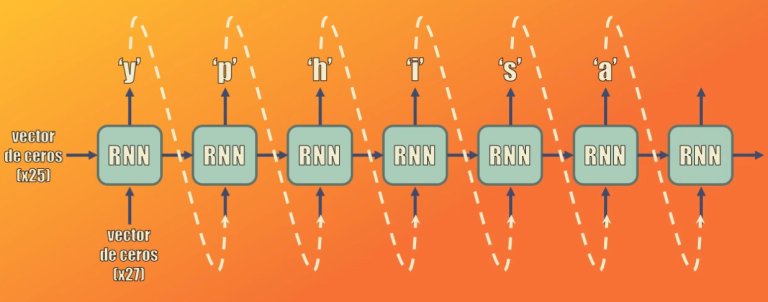

El proceso se repite de forma iterativa, generando uno a uno los caracteres de la predicción, hasta que se cumpla una de estas dos condiciones: que el número de caracteres generados sea 50 (es decir que el nombre generado contendrá máximo 50 caracteres) o que el último carácter generado corresponda al cambio de línea (lo cual indica el fin del nombre):

In [56]:
# Crear x_(t+1) = y_t, y a_t = a_(t-1)
          x = to_categorical(ix,tam_alfabeto).reshape(1,1,tam_alfabeto)
          a = K.eval(a)

          # Actualizar contador y continuar
          contador += 1

          # Agregar fin de línea al nombre generado en caso de tener más de 50 caracteres
          if (contador == 50):
            nombre_generado += '\n'

print(nombre_generado)

IndentationError: unexpected indent (<ipython-input-56-8a7f3f12efb2>, line 2)

Finalmente, usando esta función podemos generar 100 diferentes nombres:

In [59]:
import tensorflow as tf
import tensorflow.keras.backend as K

def generar_nombre(modelo, car_a_num, tam_alfabeto, n_a):
    """
    Genera un nombre usando el modelo RNN.

    Args:
        modelo: El modelo RNN entrenado.
        car_a_num: Un diccionario que mapea caracteres a índices.
        tam_alfabeto: El tamaño del alfabeto.
        n_a: El número de unidades en la capa oculta.

    Returns:
        El nombre generado.
    """
    # ... (your existing code) ...

    while (car != fin_linea and contador != 50):
        # Generar predicción usando la celda RNN
        # Use tf.constant instead of K.constant
        a, _ = celda_recurrente(tf.constant(x), initial_state=tf.constant(a))
        y = capa_salida(a)
        prediccion = K.eval(y)

    # ... (rest of your code) ...

In [62]:
import tensorflow as tf
import tensorflow.keras.backend as K

def generar_nombre(modelo, car_a_num, tam_alfabeto, n_a):
    """
    Genera un nombre usando el modelo RNN.

    Args:
        modelo: El modelo RNN entrenado.
        car_a_num: Un diccionario que mapea caracteres a índices.
        tam_alfabeto: El tamaño del alfabeto.
        n_a: El número de unidades en la capa oculta.

    Returns:
        El nombre generado.
    """
    # ... (your existing code) ...

    # Initialize 'car' and other variables before the loop
    car = ''  # Initialize with an empty string or a starting character
    contador = 0
    nombre_generado = ''

    # Assuming 'ix' is the index of the initial character
    ix = car_a_num['\t'] # Initialize with the index of the start token

    # initialize 'a' with zeros
    a = np.zeros((1, n_a))

    while (car != fin_linea and contador != 50):
        # Generar predicción usando la celda RNN
        # Use tf.constant instead of K.constant
        a, _ = celda_recurrente(tf.constant(x), initial_state=tf.constant(a))
        y = capa_salida(a)
        prediccion = K.eval(y)

        # Get the index of the predicted character
        ix = np.argmax(prediccion)

        # Get the predicted character from the index
        car = [k for k, v in car_a_num.items() if v == ix][0] # changed ind_a_car to car_a_num

        # Add the predicted character to the generated name
        nombre_generado += car

        # Update x_(t+1) = y_t, and y a_t = a_(t-1)
        x = to_categorical(ix,tam_alfabeto).reshape(1,1,tam_alfabeto)
        a = K.eval(a)

        # Update counter and continue
        contador += 1

        # Add newline to generated name if it has more than 50 characters
        if (contador == 50):
            nombre_generado += '\n'

    print(nombre_generado)

In [60]:
for i in range(100):
    generar_nombre(modelo,car_a_ind,tam_alfabeto,n_a)

NameError: name 'car' is not defined

Para finalizar, veamos algunos ejemplos de nombres generados por el modelo

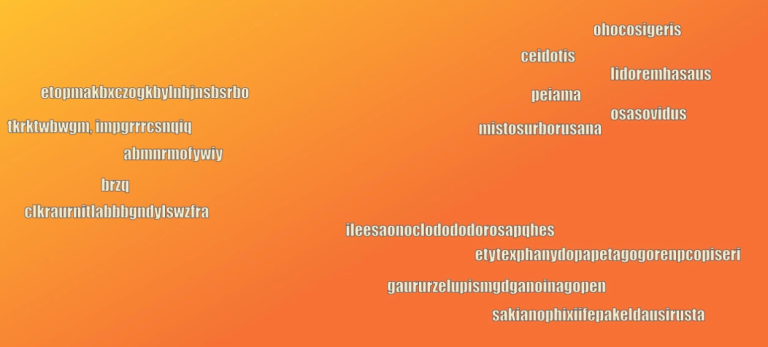

A la izquierda vemos algunos nombres generados antes del entrenamiento. Podemos ver que son nombres totalmente aleatorios, y es obvio, pues aún no hemos iniciado el entrenamiento.

A la derecha vemos algunos nombres generados por el modelo después de 10000 iteraciones de entrenamiento. Acá es evidente que la generación de nombres deja de ser aleatoria, y que las secuencias generadas se asemejan más a nombres reales de dinosaurios.

En particular podemos ver que los primeros nombres, los de extension más corta, parecen realmente nombres de dinosaurios.

Sin embargo observamos un comportamiento particular: a medida que la extensión de la secuencia generada es más grande (como en los cuatro últimos nombres generados) el nombre parece más aleatorio y no se asemeja al nombre de un dinosaurio.